# Train VAE model

This notebook will first try to train the current VAE model before modifying the loss function to work with count data. Specifically, the loss function uses the loss from defined in [Eraslan et al.](https://www.nature.com/articles/s41467-018-07931-2). This publication uses the zero-inflated negative binomial (ZINB) distribution, which models highly sparse and overdispersed count data. ZINB is a mixture model that is composed of
   1. A point mass at 0 to represent the excess of 0's
   2. A NB distribution to represent the count distribution

Params of ZINB conditioned on the input data are estimated. These params include the mean and dispersion parameters of the NB component (μ and θ) and the mixture coefficient that represents the weight of the point mass (π)

We adopted code from: https://github.com/theislab/dca/blob/master/dca/loss.py

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
from cm_modules import utils, train_vae_modules

Using TensorFlow backend.


In [2]:
# Set seeds to get reproducible VAE trained models
train_vae_modules.set_all_seeds()

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "test_vae_training", "config_current_vae.tsv")
)

params = utils.read_config(config_filename)

dataset_name = params["dataset_name"]

raw_compendium_filename = params["raw_compendium_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]

In [4]:
# Try normalzing the data
# Here we are normalizing the microbiome count data per taxon
# so that each taxon is in the range 0-1
train_vae_modules.normalize_expression_data(
    base_dir, config_filename, raw_compendium_filename, normalized_compendium_filename
)

input: dataset contains 11857 samples and 1232 genes
Output: normalized dataset contains 11857 samples and 1232 genes


In [5]:
test1 = pd.read_csv(raw_compendium_filename, sep="\t")
test2 = pd.read_csv(normalized_compendium_filename, sep="\t")

In [6]:
test1.head()

,Unnamed: 0,Bacteria Actinobacteriota Actinobacteria Bifidobacteriales Bifidobacteriaceae Bifidobacterium,Bacteria Bacteroidota Bacteroidia Bacteroidales Bacteroidaceae Bacteroides,Bacteria Actinobacteriota Coriobacteriia Coriobacteriales Coriobacteriaceae Collinsella,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Agathobacter,Bacteria Firmicutes Negativicutes Veillonellales-Selenomonadales Selenomonadaceae Megamonas,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Blautia,Bacteria Firmicutes Clostridia Oscillospirales Ruminococcaceae Faecalibacterium,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Anaerostipes,Bacteria Bacteroidota Bacteroidia Bacteroidales Prevotellaceae Prevotella,...,Bacteria Actinobacteriota Acidimicrobiia Microtrichales Ilumatobacteraceae NA,Bacteria Verrucomicrobiota Verrucomicrobiae Pedosphaerales Pedosphaeraceae ADurb.Bin063-1,Bacteria Proteobacteria Alphaproteobacteria Caulobacterales Caulobacteraceae PMMR1,Bacteria Bacteroidota Bacteroidia Flavobacteriales Cryomorphaceae NA,Bacteria Bacteroidota Bacteroidia Flavobacteriales Flavobacteriaceae Pseudofulvibacter,Bacteria Proteobacteria Alphaproteobacteria Rickettsiales Rickettsiaceae NA,Bacteria Bacteroidota Bacteroidia Flavobacteriales Flavobacteriaceae Gelidibacter,Bacteria Proteobacteria Gammaproteobacteria Burkholderiales Comamonadaceae Ideonella,Bacteria Proteobacteria Alphaproteobacteria Rhizobiales Xanthobacteraceae Rhodoplanes,Bacteria Proteobacteria Alphaproteobacteria Sphingomonadales Sphingomonadaceae Rhizorhapis
0,PRJDB5310_DRR077057,311,423,0,0,0,0,429,0,0,...,0,0,0,0,0,0,0,0,0,0
1,PRJDB5310_DRR077058,243,313,0,0,0,13,239,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PRJDB5310_DRR077059,0,255,0,196,0,477,297,51,0,...,0,0,0,0,0,0,0,0,0,0
3,PRJDB5310_DRR077060,698,0,167,159,0,158,151,23,0,...,0,0,0,0,0,0,0,0,0,0
4,PRJDB5310_DRR077061,39,335,64,96,61,189,104,68,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test2.head()

,Unnamed: 0,Bacteria Actinobacteriota Actinobacteria Bifidobacteriales Bifidobacteriaceae Bifidobacterium,Bacteria Bacteroidota Bacteroidia Bacteroidales Bacteroidaceae Bacteroides,Bacteria Actinobacteriota Coriobacteriia Coriobacteriales Coriobacteriaceae Collinsella,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Agathobacter,Bacteria Firmicutes Negativicutes Veillonellales-Selenomonadales Selenomonadaceae Megamonas,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Blautia,Bacteria Firmicutes Clostridia Oscillospirales Ruminococcaceae Faecalibacterium,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Anaerostipes,Bacteria Bacteroidota Bacteroidia Bacteroidales Prevotellaceae Prevotella,...,Bacteria Actinobacteriota Acidimicrobiia Microtrichales Ilumatobacteraceae NA,Bacteria Verrucomicrobiota Verrucomicrobiae Pedosphaerales Pedosphaeraceae ADurb.Bin063-1,Bacteria Proteobacteria Alphaproteobacteria Caulobacterales Caulobacteraceae PMMR1,Bacteria Bacteroidota Bacteroidia Flavobacteriales Cryomorphaceae NA,Bacteria Bacteroidota Bacteroidia Flavobacteriales Flavobacteriaceae Pseudofulvibacter,Bacteria Proteobacteria Alphaproteobacteria Rickettsiales Rickettsiaceae NA,Bacteria Bacteroidota Bacteroidia Flavobacteriales Flavobacteriaceae Gelidibacter,Bacteria Proteobacteria Gammaproteobacteria Burkholderiales Comamonadaceae Ideonella,Bacteria Proteobacteria Alphaproteobacteria Rhizobiales Xanthobacteraceae Rhodoplanes,Bacteria Proteobacteria Alphaproteobacteria Sphingomonadales Sphingomonadaceae Rhizorhapis
0,PRJDB5310_DRR077057,0.001496,0.000948,0.000000,0.000000,0.000000,0.000000,0.004278,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PRJDB5310_DRR077058,0.001169,0.000702,0.000000,0.000000,0.000000,0.000046,0.002383,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PRJDB5310_DRR077059,0.000000,0.000572,0.000000,0.001081,0.000000,0.001694,0.002962,0.001032,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PRJDB5310_DRR077060,0.003358,0.000000,0.004034,0.000877,0.000000,0.000561,0.001506,0.000465,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PRJDB5310_DRR077061,0.000188,0.000751,0.001546,0.000529,0.003158,0.000671,0.001037,0.001376,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs"),
]

NN_architecture = params["NN_architecture"]

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)

input dataset contains 11857 samples and 1232 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/alexandra/anaconda3/envs/microbe/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 8893 samples, validate on 2964 samples
Epoch 1/5
8893/8893 [==============================] - 10s 1ms/step - loss: 0.0694 - kl_loss: 9.3014 - zinb_loss: 0.0694 - val_loss: 0.0675 - val_kl_loss: 2.8620 - val_zinb_loss: 0.0675
Epoch 2/5
8893/8893 [==============================] - 9s 1ms/step - loss: 0.0683 - kl_loss: 7.7962 - zinb_loss: 0.0683 - val_loss: 0.0677 - val_kl_loss: 6.5045 - val_zinb_loss: 0.0678
Epoch 3/5
8893/8893 [==============================] - 9s 1ms/step - loss: 0.0682 - kl_loss: 11.3457 - zinb_loss: 0.0682 - val_loss: 0.0678 - val_kl_loss: 8.2019 - val_zinb_loss: 0.0678
Epoch 4/5
8893/8893 [==============================] - 9s 1ms/step - loss: 0.0681 - kl_loss: 11.7715 - zinb_loss: 0.0682 - val_loss: 0.0677 - val_kl_loss: 8.7920 - val_zinb_loss: 0.0677
Epoch 5/5
8893/8893 [==============================] - 9s 1ms/step - loss: 0.0681 - kl_loss: 11.8440 - zinb_loss: 0.0681 - val_loss: 0.0675 - val_kl_loss: 9.1466 - val_zinb_loss: 0.0675


TypeError: 'Tensor' object is not callable

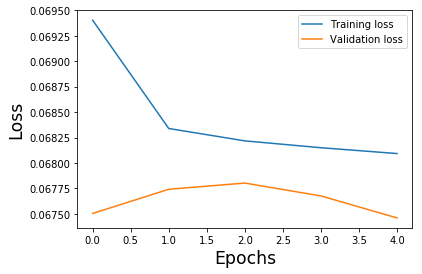

In [9]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename, normalized_compendium_filename)

In [ ]:
# Plot training and validation loss separately
stat_logs_filename = "logs/DCA/tybalt_2layer_30latent_stats.tsv"

stats = pd.read_csv(stat_logs_filename, sep="\t", index_col=None, header=0)

In [ ]:
plt.plot(stats["loss"])

In [ ]:
plt.plot(stats["val_loss"], color="orange")